# 第二次重构

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from Lowpass import LowPassFilter


def sigmoid(x):
    return 2*(1 / (1 + np.exp(-(np.array(x)))) -0.5)


def rk4(h, y, inputs, f):
    '''
    用于数值积分的rk4函数。
    args:
        h - 步长
        y - 当前状态量
        inputs - 外界对系统的输入
        f - 常微分或偏微分方程
    return:
        y_new - 新的状态量,即经过h时间之后的状态量
    '''
    k1 = f(y, inputs)
    k2 = f(y + h / 2 * k1, inputs)
    k3 = f(y + h / 2 * k2, inputs)
    k4 = f(y + h * k3, inputs)

    y_new = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_new

def myplot(t, listarray, name, linestyle='-'):
    plt.plot(t,listarray, label=name, linestyle=linestyle)
    plt.legend()
    
t = range(500)
sigmoid(.1*.462*6)

In [ ]:
np.array([3,2,1])-np.array([2,1,2])

In [ ]:
class Neuron:
    def __init__(self, num=3, I=0, potential=None, trajectory=None, tau=0.1, dt=1) -> None:
        self.num = num
        self.I = I
        assert self.num == np.size(I), "The input size is different from the neuron number."
        if potential is None:
            self.potential = self.activation(I)
        else:
            self.potential = potential
        if trajectory is None:
            self.trajectory = self.potential
        # self.potentialnew = self.potential
        self.trajectorynew = self.trajectory
        self.delta = self.potential - self.trajectory        
        self.tau = tau
        self.dt = dt
        self.lowpassfilter = LowPassFilter(self.potential, self.trajectory, self.tau, self.dt)
    
    def updateDelta(self):
        self.delta = self.potential - self.trajectory 
        return self.delta
    
    def activation(self, I):
        return sigmoid(I)    
    
    def step(self, dt, I):
        if dt is None:
            dt = self.dt
        assert self.num == np.size(I), "The input size is different from the neuron number."
        self.potential = self.activation(I)
        self.trajectory = self.potential
        self.trajectorynew = self.lowpassfilter.step(dt=dt, current=self.potential)
        # self.potentialnew = self.potential
        return self.trajectorynew

    def update(self):
        # self.potential = self.potentialnew
        self.trajectory = self.trajectorynew
        self.updateDelta()
        self.lowpassfilter.update()
  

In [ ]:
# 测试Neuron
num = 6
I = np.zeros(num).reshape(num,1)
KC = Neuron(num,I, tau=0.01)
plist, tlist = [], []
Ilist = []
for i in t:
    if i < 200:
        I = np.array([0.5 * i / 100, 0.5 * i / 100 *2, 1.5 * i / 100, 0.5 * i / 100 *4, 2.5 * i / 100, 0.5 * i / 100 *6])
    elif 200 <= i < 300 :
        I = np.array([0, 0, 0, 0, 0, 0])
    elif 300 <= i < 325:
        I = np.array([4 * (i - 300) / 100, 4 * (i - 300) / 100 *2, 4 * (i - 300) / 100, 4 * (i - 300) / 100 *2, 4 * (i - 300) / 100, 4 * (i - 300) / 100 *2])
    elif 325<= i < 400:
        I = np.array([1, 2, 1, 2, 1, 2])
    else:
        I = np.array([0, 0, 0, 0, 0, 0])
    
    Ilist.append(I)
    tra = KC.step(1, I)
    # print(tra)
    plist.append(KC.potential)
    KC.update()
    tlist.append(tra[0])  # 不知道为什么正常是[],返回[[]] 
plt.figure()
plt.plot(t, plist)
plt.plot(t, tlist, '--')
plt.figure()
plt.plot(t,Ilist)
# plt.plot(t,np.array(plist).T[0])
# plt.plot(t,np.array(tlist).T[0][0])
# plt.plot(t,np.array(plist).T[1])
# plt.plot(t,np.array(tlist).T[1][0])
plt.show()    


In [100]:
class Synapse:
    def __init__(self, preNeuron:Neuron, postNeuron:Neuron, weight=None, reward=0, alpha=1, beta=1, dt=0.01, tau=1,) -> None:
        self.preNeuron = preNeuron
        self.postNeuron = postNeuron 
        self.preNum = self.preNeuron.num
        self.postNum = self.postNeuron.num
        self.preI = self.preNeuron.I
        self.postI = self.postNeuron.I
        self.prePotential = self.preNeuron.potential
        self.prePotentialnew = self.prePotential 
        self.preTrajectory = self.prePotential  # self.preNeuron.trajectory
        self.preTrajectorynew = self.preTrajectory
        self.postPotential = self.postNeuron.potential
        self.postPotentialnew = self.postPotential
        self.postTrajectory = self.postPotential  # self.preNeuron.trajectory
        self.postTrajectorynew = self.postTrajectory
        if weight is not None:
            self.weight = weight
        else:
            assert weight is not None, "The weight is None."
        assert self.weight.shape == (self.postNum, self.preNum), "The shape of the weight does not match. "
        self.reward = np.array(reward)
        self.alpha = alpha
        self.beta = beta
        self.dt = dt
        self.tau = tau
        
    def derivative(self, state, inputs=0):
        w = state
        Dw = (np.matmul(self.beta * np.tile(self.postTrajectory, self.postNum), (self.alpha * self.preTrajectory.T - w)) * self.reward) / self.tau
        return Dw
    
    def step(self, dt, preI, inputs=0):
        self.preI = preI
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        self.weight = statenew
        self.preTrajectorynew = self.preNeuron.step(self.preNeuron.dt, self.preI)
        self.postI = np.matmul(self.weight, self.prePotential)
        self.postTrajectorynew = self.postNeuron.step(self.postNeuron.dt, self.postI)
        return statenew
    
    def update(self):
        self.prePotential = self.preNeuron.potential     
        self.preTrajectory = self.preTrajectorynew
        self.postPotential = self.postNeuron.potential
        self.postTrajectory = self.postTrajectorynew  
        # self.preNeuron.potential = self.prePotentialnew 
        # self.postNeuron.potential = self.postPotential
        self.preNeuron.update()
        self.postNeuron.update()

In [ ]:
class SynapseKM(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=0.01, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
    
    def derivative(self, state, inputs=0):
        return super().derivative(state, inputs)
    
    def step(self, dt, preI, inputs=0):
        return super().step(dt, preI, inputs)

    def update(self):
        return super().update()



In [101]:
class SynapseKD(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=0.01, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
        self.delta = self.preNeuron.delta
        
    def derivative(self, state, inputs=0):
        w = state
        delta = self.delta
        Dw = (np.matmul(self.beta * np.tile(self.postPotential, self.postNum), (self.alpha * delta.T - w)) * self.reward) / self.tau
        return Dw
    
    def step(self, dt, preI, inputs=0):
        return super().step(dt, preI, inputs)
    
    def update(self):
        self.preNeuron.trajectory = self.preTrajectorynew
        self.delta = self.preNeuron.updateDelta()
        return super().update()



In [114]:
from cycler import cycler
cc = (cycler(color=list('rgb')) +
      cycler(linestyle=['-', '--', '-.']))
for d in cc:
    print(d[])

r
g
b


In [ ]:
class SynapseDK(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, weight=None, reward=0, alpha=1, beta=1, dt=0.01, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, weight, reward, alpha, beta, dt, tau)
        self.delta = self.postNeuron.delta
        
    def derivative(self, state, inputs=0):
        w = state
        delta = self.delta
        Dw = (np.matmul(self.beta * np.tile(delta, self.postNum), (self.alpha * self.preTrajectory.T - w)) * self.reward) / self.tau
        return Dw
    
    def step(self, dt, preI, inputs=0):
        return super().step(dt, preI, inputs)
    
    def update(self):
        self.delta = self.postNeuron.updateDelta()
        return super().update()

In [ ]:
t = range(500)
numKC, numMBON, numDAN = 6, 3, 3

In [ ]:
# 测试synapseKM
initWeightKM = np.ones([numMBON,numKC]) * .1
IKC = np.ones(numKC).reshape(numKC,1)
KC = Neuron(numKC,IKC)
IMBON = np.matmul(initWeightKM, KC.potential)
MBON = Neuron(numMBON,IMBON)

skm = SynapseKM(KC, MBON, initWeightKM, 1)
skmweight,KCp,KCt,MBONp,MBONt = [],[],[],[],[]
KCI, MBONI = [], []
for i in t:
    KCI.append(skm.preI[0][0])
    MBONI.append(skm.postI[0][0])
    KCp.append(skm.prePotential[0][0])
    KCt.append(skm.preTrajectory[0][0])
    MBONp.append(skm.postPotential[0][0])
    MBONt.append(skm.postTrajectory[0][0])
    KMWeight = skm.step(.1)
    skm.update()
    skmweight.append(KMWeight[0][0])

    
print(MBONp[:10])
print(MBONp[::-1][:10])
plt.plot(t,KCI,label='KCI')
plt.plot(t,MBONI,label='MBONI')
plt.plot(t,skmweight, label='skmweight')
plt.plot(t,KCp, label='KCp')
plt.plot(t,KCt, label='KCt',linestyle='--')
plt.plot(t,MBONp, label='MBONp')
plt.plot(t,MBONt, label='MBONt')
plt.legend()
plt.show()


[0.] [0.46211716] [0.46211716]
[0.] [0.46211716] [0.46211716]
[0.00071128] [0.46290324] [0.46219196]
[0.         0.         0.00071128 0.00135421 0.0019353  0.00246044
 0.00293494 0.00336362 0.00375086 0.00410058]


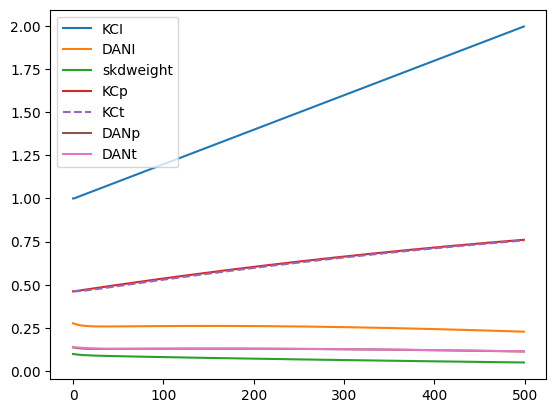

In [112]:
# 测试synapseKD
initWeightKD = np.ones([numDAN,numKC]) * .1
IKC = np.ones(numKC).reshape(numKC,1)
KC = Neuron(numKC,IKC)
IDAN = np.matmul(initWeightKD, KC.potential)
DAN = Neuron(numDAN,IDAN)

skd = SynapseKD(KC, DAN, initWeightKD, 1, 10)
skdweight,KCp,KCt,DANp,DANt = [],[],[],[],[]
KCI, DANI = [], []
for i in t:
    if i<3:
        print(skd.delta[0],skd.preNeuron.potential[0], skd.preNeuron.trajectory[0]) 
    # skd.preNeuron.I = np.ones(numKC).reshape(numKC,1) + i/500
    KCI.append(skd.preI[0][0])
    DANI.append(skd.postI[0][0])
    KCp.append(skd.prePotential[0][0])
    KCt.append(skd.preTrajectory[0][0])
    DANp.append(skd.postPotential[0][0])
    DANt.append(skd.postTrajectory[0][0])
    KDWeight = skd.step(.02,np.ones(numKC).reshape(numKC,1) + i/500)
    skd.update()
    skdweight.append(KDWeight[0][0])
print([np.array(KCp)-np.array(KCt)][0][:10])   

myplot(t,KCI,'KCI')
myplot(t,DANI,'DANI')
myplot(t,skdweight,'skdweight')
myplot(t,KCp,'KCp')
myplot(t,KCt,'KCt','--')
myplot(t,DANp,'DANp')
myplot(t,DANt,'DANt')
plt.show()

In [ ]:
# 测试synapseDK
initWeightDK = np.ones([numKC,numDAN]) * .1
IDAN = np.ones(numDAN).reshape(numDAN,1)

DAN = Neuron(numDAN,IDAN)
IKC = np.matmul(initWeightDK, DAN.potential)
KC = Neuron(numKC,IKC)

sdk = SynapseDK(DAN, KC, initWeightDK, 1)
sdkweight,KCp,KCt,DANp,DANt = [],[],[],[],[]
KCI, DANI = [], []
for i in t:
    KDWeight = sdk.step(.1)
    sdkweight.append(KDWeight[0][0])
    DANp.append(sdk.prePotential[0][0])
    DANt.append(sdk.preTrajectory[0][0])
    KCp.append(sdk.postPotential[0][0])
    KCt.append(sdk.postTrajectory[0][0])
    sdk.update()

myplot(t,sdkweight,'sdkweight')
myplot(t,DANp,'DANp')
myplot(t,DANt,'DANt')
myplot(t,KCp,'KCp')
myplot(t,KCt,'KCt')
plt.show()
print(KCp[:20])

# 第一次重构

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


def sigmoid(x):
    return 1 / (1 + np.exp(-(np.array(x)-2)))


def rk4(h, y, inputs, f):
    '''
    用于数值积分的rk4函数。
    args:
        h - 步长
        y - 当前状态量
        inputs - 外界对系统的输入
        f - 常微分或偏微分方程
    return:
        y_new - 新的状态量,即经过h时间之后的状态量
    '''
    k1 = f(y, inputs)
    k2 = f(y + h / 2 * k1, inputs)
    k3 = f(y + h / 2 * k2, inputs)
    k4 = f(y + h * k3, inputs)

    y_new = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return y_new

# class low_pass_filter:
#     def __init__(self, state, inputs=0):
        
#     history = state
#     Dhistory = self.tau_lowpass * (self.PreNeuron - history)  
#     return Dhistory

def myplot(t, listarray, name):
    plt.plot(t,listarray, label=name)
    plt.legend()
 
    
t = range(100)

In [ ]:
class Neuron:
    def __init__(self, num=3, tau=0.1, dt=1, I=0, potential=None, history=None) -> None:
        self.num = num
        assert self.num == np.size(I), "The input size is different from the neuron number."
        # self.input = np.zeros(self.num, dtype=float).reshape(self.num,1)
        if potential is None:
            self.potential = self.activation(I) #np.zeros(self.num, dtype=float).reshape(self.num,1) 
        else:
            self.potential = potential
        if history is None:
            self.history = self.potential # np.zeros(self.num, dtype=float).reshape(self.num,1)
        self.delta = self.potential - self.history
        self.tau = tau
        self.dt = dt
    
    def updateDelta(self):
        self.delta = self.potential - self.history
        return self.delta
        
    # def derivative(self, state, inputs=0):
    #     history = state
    #     # Dhistory = self.tau * (sigmoid(self.potential) - history)
    #     Dhistory = self.tau * (inputs - history)
    #     return Dhistory

    def activation(self, I):
        return sigmoid(I)
    
    def step(self, dt, inputs=0,):
        if dt is None:
            dt = self.dt
        I = inputs
        self.potential = self.activation(I)
        state = self.history
        statenew = rk4(dt, state, self.potential, self.derivative)
        self.history = statenew
        return statenew
    

In [ ]:
# 测试Neuron
kc = Neuron(6)
clist, hlist, dlist = [], [], []
for i in t:
    if i < 200:
        kc.potential = (np.zeros(6) + 0.5 * i / 100).reshape(6,1)
    elif 200 <= i < 300 :
        kc.potential = np.zeros(6).reshape(6,1)
    elif 300 <= i < 325:
        kc.potential = (np.zeros(6) +4 * (i - 300) / 100).reshape(6,1)
    elif 325<= i < 400:
        kc.potential = np.ones(6).reshape(6,1)
    else:
        kc.potential = np.zeros(6).reshape(6,1)
    dlist.append(kc.updateDelta()[0][0])
    # kc.potential = sigmoid(kc.potential)
    clist.append(kc.potential[0][0])
    hlist.append(kc.step(1)[0][0])
myplot(t, clist, 'cur')
myplot(t, hlist, 'his')
myplot(t, dlist, 'delta')
plt.show()

In [ ]:
class Synapse:
    def __init__(self, preNeuron:Neuron, postNeuron:Neuron, reward=0, alpha=1, beta=1, dt=0.01, tau=1,) -> None:
        self.preNeuron = preNeuron
        self.postNeuron = postNeuron
        self.numPre = self.preNeuron.num
        self.numPost = self.postNeuron.num
        self.prepotential = self.preNeuron.potential
        self.preHistory = self.prepotential  # self.preNeuron.history
        self.postpotential = self.postNeuron.potential
        self.postHistory = self.postpotential  # self.postNeuron.history
        self.weight = np.zeros([self.numPost, self.numPre])  # TODO add weight init
        self.reward = np.array(reward)
        self.alpha = alpha
        self.beta = beta
        self.dt = dt
        self.tau = tau
        
    def derivative(self, state, inputs=0):
        w = state
        Dw = (np.matmul(self.beta * np.tile(self.postHistory, self.numPost), (self.alpha * self.preHistory.T - w)) * self.reward) / self.tau
        return Dw
    
    def step(self, dt, inputs=0):
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        self.weight = statenew
        # self.preNeuron.potential = self.prepotential
        self.preHistory = self.preNeuron.step(self.preNeuron.dt)
        self.postpotential = np.matmul(self.weight, self.prepotential)
        # self.postNeuron.potential = self.postpotential # TODO add update（）
        self.postHistory = self.postNeuron.step(self.postNeuron.dt)
        return statenew
        
    def update():
        
        
class SynapseKM(Synapse):
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, reward=1, alpha=1, beta=1, dt=0.01, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, reward, alpha, beta, dt, tau)
    
    def derivative(self, state, inputs=0):
        return super().derivative(state, inputs)
    
    def step(self, dt, inputs=0):
        return super().step(dt, inputs)

class SynapseKD(Synapse):  # 3,1
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, reward=1, alpha=1, beta=1, dt=0.01, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, reward, alpha, beta, dt, tau)
        self.delta = self.preNeuron.delta
    
    def derivative(self, state, inputs=0):
        w = state
        delta = self.delta
        Dw = (np.matmul(self.beta * np.tile(self.postpotential, self.numPost), (self.alpha * delta.T - w)) * self.reward) / self.tau
        return Dw
    
    def step(self, dt, inputs=0):
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        self.weight = statenew
        self.preNeuron.potential = self.prepotential
        self.preHistory = self.preNeuron.step(self.preNeuron.dt)
        self.delta = self.preNeuron.updateDelta()
        self.postpotential = np.matmul(self.weight, self.prepotential)
        self.postNeuron.potential = self.postpotential
        self.postHistory = self.postNeuron.step(self.postNeuron.dt)
        return statenew    

class SynapseDK(Synapse):  # 2,3
    def __init__(self, preNeuron: Neuron, postNeuron: Neuron, reward=1, alpha=1, beta=1, dt=0.01, tau=1) -> None:
        super().__init__(preNeuron, postNeuron, reward, alpha, beta, dt, tau)
        self.delta = self.postNeuron.delta
     
    def derivative(self, state, inputs=0):
        w = state
        delta = self.delta
        Dw = (np.matmul(self.beta * np.tile(delta, self.numPost), (self.alpha * self.preHistory.T - w)) * self.reward) / self.tau
        return Dw
    
    def step(self, dt, inputs=0):
        if dt is None:
            dt = self.dt
        state = self.weight
        statenew = rk4(dt, state, inputs, self.derivative)
        self.weight = statenew
        self.weight = [[ 0 if i < 0 else i for i in row] for row in self.weight]
        
        self.preNeuron.potential = self.prepotential
        self.preHistory = self.preNeuron.step(self.preNeuron.dt)
        
        self.postpotential = np.matmul(self.weight, self.prepotential)
        self.postNeuron.potential = self.postpotential
        self.postHistory = self.postNeuron.step(dt=self.postNeuron.dt)
        self.delta = self.postNeuron.updateDelta()
        
        return statenew

In [ ]:
# 测试SynapseKM
KC = Neuron(6)
KC.potential = KC.history = np.ones(6).reshape(6,1)
# KC.history = KC.potential
# KC.step(1)

MBON = Neuron(3)
MBON.potential = MBON.history = np.ones(3).reshape(3,1)
# MBON.step(1)

skm = SynapseKM(KC,MBON)
skmlist = []
kcclist = []
kchlist = []
mbonclist = []
mbonhlist = []
# print(f"{'w':<15} {'prec':^10} {'postc':>20}")
for i in t:
    KMWeight = skm.step(.1)[0][0]
    skmlist.append(KMWeight)
    kcclist.append(skm.prepotential[0][0])
    kchlist.append(skm.preHistory[0][0])
    # skm.weight[0][0] = 1
    # print(skm.weight[0][0], skm.prepotential[0][0], np.matmul(skm.weight, skm.prepotential)[0][0], skm.weight[0][0] * skm.prepotential[0][0])
    mbonclist.append(skm.postpotential[0][0])
    mbonhlist.append(skm.postHistory[0][0])
    
plt.figure()
myplot(t, skmlist, 'kmlist')
myplot(t, kcclist, 'kcc')
myplot(t, kchlist, 'kch')
myplot(t, mbonclist, 'mbonc')
myplot(t, mbonhlist, 'mbonh')
plt.show()



In [ ]:
# 测试SynapseDK 2,3
DAN = Neuron(3)
DAN.potential = DAN.history = np.ones(3).reshape(3,1)

KC = Neuron(6)
KC.potential = KC.history = np.ones(6).reshape(6,1)

sdk = SynapseDK(DAN, KC)
sdklist = []
kcclist = []
kchlist = []
danclist = []
danhlist = []

for i in t:
    print(sdk.prepotential[0][0], sdk.preHistory[0][0], sdk.postpotential[0][0], sdk.postHistory[0][0], sdk.weight[0][0])
    danclist.append(sdk.prepotential[0][0])
    danhlist.append(sdk.preHistory[0][0])
    kcclist.append(sdk.postpotential[0][0])
    kchlist.append(sdk.postHistory[0][0])
    sdklist.append(sdk.step(.01)[0][0])

myplot(t, danclist, 'danc')
myplot(t, danhlist, 'danh')
myplot(t, kcclist, 'kcc')
myplot(t, kchlist, 'kch')
myplot(t, sdklist, 'dklist')
plt.figure()
# sdklist[:40]

In [ ]:
# 测试SynapseKD 3,1
KC = Neuron(6)
KC.potential = KC.history = np.ones(6).reshape(6,1)

DAN = Neuron(3)
DAN.potential = DAN.history = np.ones(3).reshape(3,1)

skd = SynapseKD(KC, DAN)
skdlist = []
kcclist, kchlist, danclist, danhlist = [], [], [], []
for i in t:
    KDWeight = skd.step(.01)[0][0]
    kcclist.append(skd.prepotential[0][0])
    kchlist.append(skd.preHistory[0][0])
    danclist.append(skd.postpotential[0][0])
    danhlist.append(skd.postHistory[0][0])
    skdlist.append(KDWeight)
myplot(t, skdlist, 'kdlist')
myplot(t, kcclist, 'kcc')
myplot(t, kchlist, 'kch')
myplot(t, danclist, 'danc')
myplot(t, danhlist, 'danh')
# skdlist[:40]

In [ ]:
# 测试整体
KC = Neuron(6)
KC.potential = np.array([[1,1,0,0,0,0]]).T

MBON = Neuron(3)
MBON.potential = np.array([[0,1,0]]).T

DAN = Neuron(3)
DAN.potential = np.array([[0,1,0]]).T

skm = SynapseKM(KC,MBON)
sdk = SynapseDK(DAN, KC)
skd = SynapseKD(KC, DAN)
